### Load Libraries

In [1]:
import json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import tiktoken
import hashlib
import warnings
import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer
import collections, itertools
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

/Users/justicearthur/anaconda3/envs/capstone/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

## Dataset Health & Schema Integrity

In [3]:
df_res = pd.read_csv("hf://datasets/opensporks/resumes/Resume/Resume.csv")
df_jd = pd.read_parquet("hf://datasets/lang-uk/recruitment-dataset-job-descriptions-english/data/train-00000-of-00001.parquet")

In [4]:
df_res.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [5]:
df_jd.head()

,Position,Long Description,Company Name,Exp Years,Primary Keyword,English Level,Published,Long Description_lang,id,__index_level_0__
0,10 + Blockchain Nodes / Masternodes to set up,*Requirements*\r\n\r\nWe're looking for a long...,MyCointainer,2y,Sysadmin,intermediate,2020-10-01T00:00:00+03:00,en,c0ca96e7-85df-50df-a64e-d934cd02a170,27461
1,10 .NET Developers (Middle and Senior level),"Greetings! My name is Maria, I am in urgent ne...",TechScout.tech,2y,.NET,intermediate,2022-03-01T00:00:00+02:00,en,64f4b7ea-36e4-5bdd-a8b1-185f32f7dc7f,27462
2,"10X Engineer (co-founder, #4 employee, USD 11-...",**Product**\r\nThe product is a live video cha...,Innoteka,5y,JavaScript,fluent,2021-07-01T00:00:00+03:00,en,b9a1303e-dd0c-5ed1-8f62-be2bc4c7da4f,27463
3,16 - Amazon Brand Manager,"Currently, TCM expanding its activities to Ukr...",FirstFive,2y,Marketing,upper,2022-01-01T00:00:00+02:00,en,99cb3f4a-9b4b-53d9-9a3b-bab2c22da346,27464
4,16 - Amazon Brand Manager,"Hello,\r\nWe, MIMIRB2B, are an outstaff compan...",MimirB2B,1y,Marketing,upper,2021-12-01T00:00:00+02:00,en,bc1419f7-28e2-582b-8d53-22e28b2f0210,27465


In [6]:
print("Resumes shape:", df_res.shape)
print("JDs shape:", df_jd.shape)

Resumes shape: (2484, 4)
JDs shape: (141897, 10)


In [7]:
print("Resumes Info:")
df_res.info()

print("Job Descriptions Info:")
df_jd.info()

Resumes Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB
Job Descriptions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141897 entries, 0 to 141896
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Position               141897 non-null  object
 1   Long Description       141897 non-null  object
 2   Company Name           141897 non-null  object
 3   Exp Years              141897 non-null  object
 4   Primary Keyword        141897 non-null  object
 5   English Level          134358 non-null  object
 6   Published              14189

In [8]:
print(" Data Types in Job Description Dataset:")
print(df_jd.dtypes)

categorical_cols = df_jd.select_dtypes(include='object').columns.tolist()
numerical_cols = df_jd.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n Categorical Columns:")
print(categorical_cols)

print("\n Numerical Columns:")
print(numerical_cols)
print("\n Summary of Numerical Features:")
display(df_jd[numerical_cols].describe())


 Data Types in Job Description Dataset:
Position                 object
Long Description         object
Company Name             object
Exp Years                object
Primary Keyword          object
English Level            object
Published                object
Long Description_lang    object
id                       object
__index_level_0__         int64
dtype: object

 Categorical Columns:
['Position', 'Long Description', 'Company Name', 'Exp Years', 'Primary Keyword', 'English Level', 'Published', 'Long Description_lang', 'id']

 Numerical Columns:
['__index_level_0__']

 Summary of Numerical Features:


,__index_level_0__
count,141897.000000
mean,98409.000000
std,40962.279911
min,27461.000000
25%,62935.000000
50%,98409.000000
75%,133883.000000
max,169357.000000


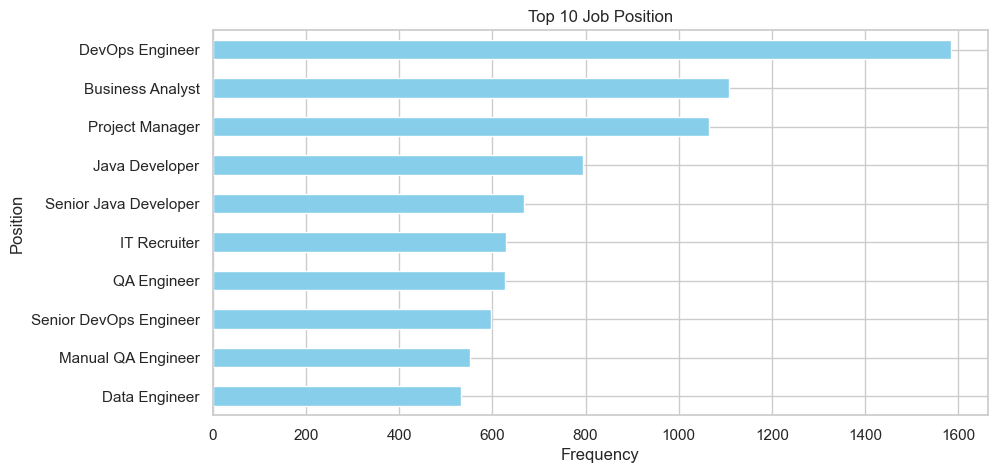

In [9]:
plt.figure(figsize=(10, 5))
df_jd['Position'].value_counts().nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Job Position")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.show()


In [10]:
print(df_res.columns)
print(df_jd.columns)

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')
Index(['Position', 'Long Description', 'Company Name', 'Exp Years',
       'Primary Keyword', 'English Level', 'Published',
       'Long Description_lang', 'id', '__index_level_0__'],
      dtype='object')


In [11]:
# Duplicate hashes
df_res["hash"] = df_res["Resume_str"].apply(lambda x: hashlib.md5(x.encode()).hexdigest())
df_res = df_res.drop_duplicates(subset='hash')
print("Unique resume hashes:", df_res["hash"].nunique())


Unique resume hashes: 2482


In [12]:
def heatmap_missing_data(df, title):
    missing_summary = df.isnull().sum()
    missing_summary = missing_summary[missing_summary > 0]

    if not missing_summary.empty:
        print(f"🔎 Columns with missing data in {title}:\n")
        for col, val in missing_summary.items():
            pct = (val / len(df)) * 100
            print(f" - {col}: {val} missing ({pct:.2f}%)")

        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="flare", linewidths=0.5, linecolor='gray')
        plt.title(f"Missing Value Matrix: {title}")
        plt.xlabel("Columns")
        plt.ylabel("Rows")
        plt.show()
    else:
        print(f"\033[1m✅ No missing data in {title}.\033[0m")

heatmap_missing_data(df_res, "Resume Dataset")

✅ No missing data in Resume Dataset.


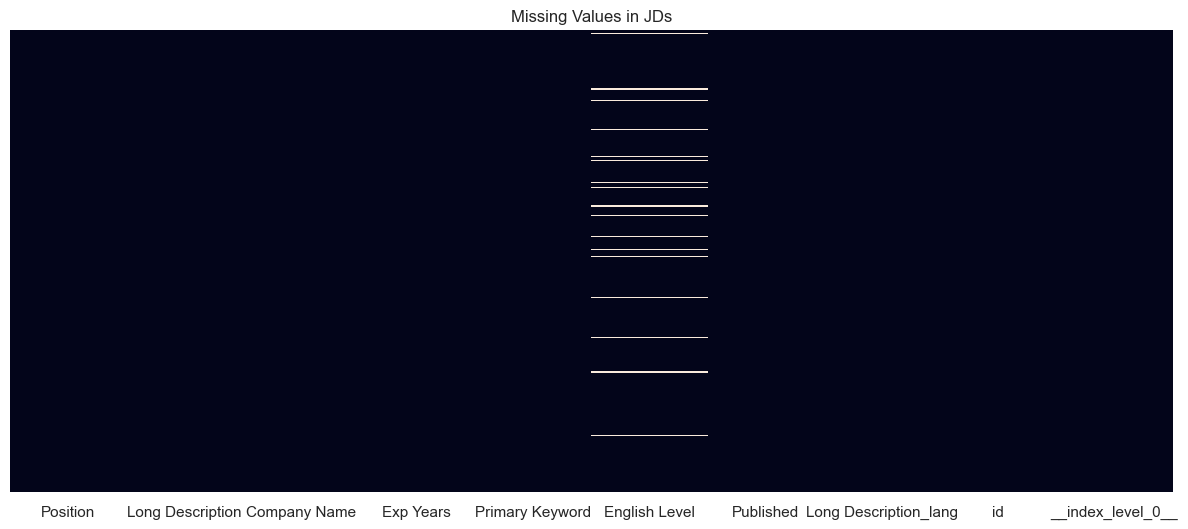

In [13]:
sns.heatmap(df_jd.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in JDs")
plt.show()

In [14]:
missing_jd = df_jd.isnull().sum()
missing_jd = missing_jd[missing_jd > 0].sort_values(ascending=False)

print("Missing Values in Job Description Dataset:")
print(missing_jd)


Missing Values in Job Description Dataset:
English Level    7539
dtype: int64


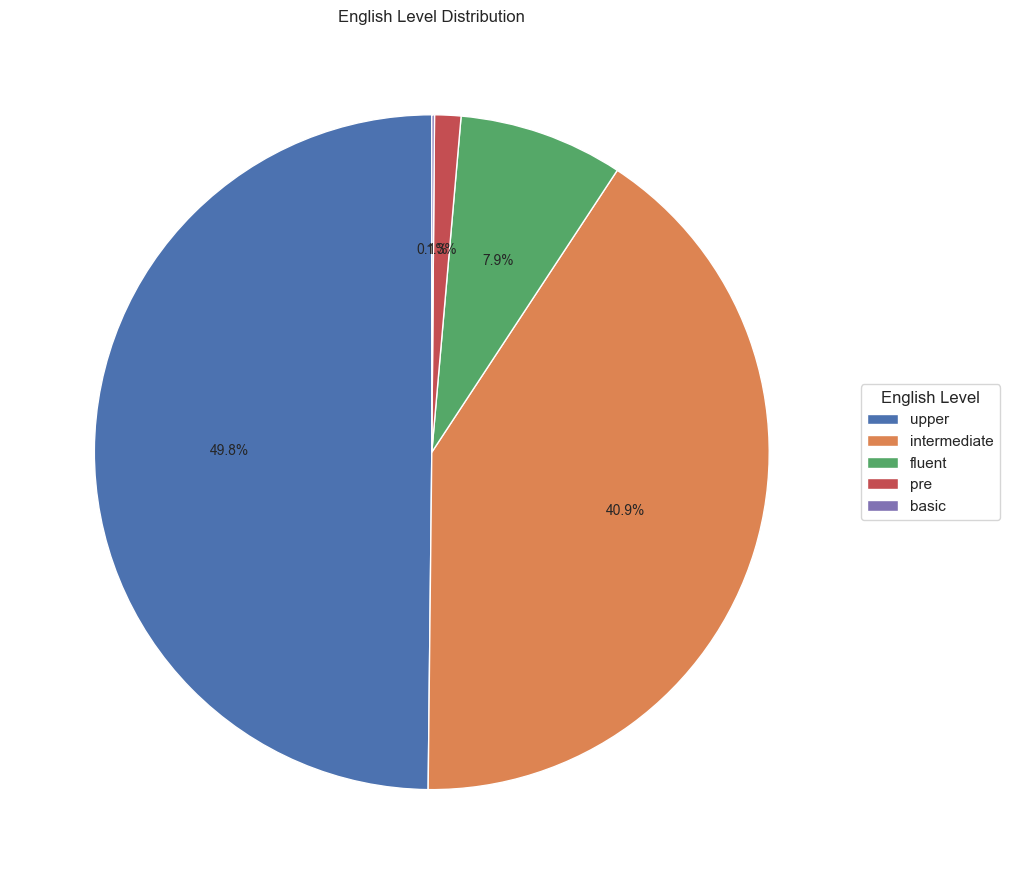

In [15]:
if 'English Level' in df_jd.columns:
    eng_counts = df_jd['English Level'].value_counts()
    plt.figure(figsize=(10, 9))
    wedges, texts, autotexts = plt.pie(
        eng_counts,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.legend(wedges, eng_counts.index, title="English Level", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title("English Level Distribution")
    plt.tight_layout()
    plt.show()


In [16]:
most_common_level = df_jd['English Level'].mode()[0]
df_jd['English Level'] = df_jd['English Level'].fillna(most_common_level)
print(f"Filled missing 'English Level' with mode: {most_common_level}")


Filled missing 'English Level' with mode: upper


### Descriptive Statistics

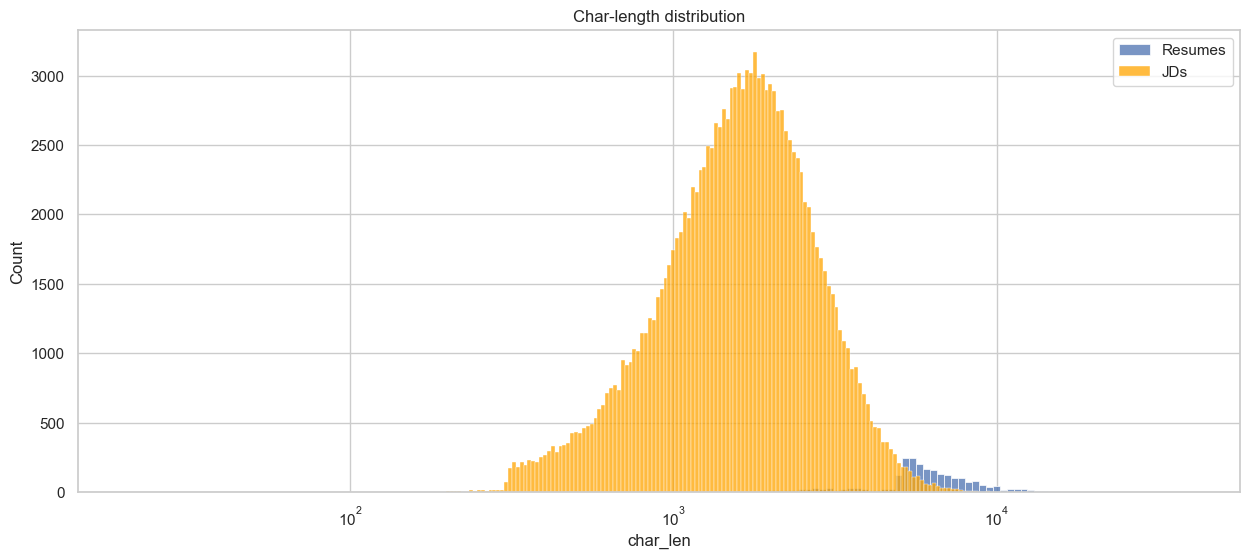

In [17]:
df_res['char_len'] = df_res['Resume_str'].str.len()
df_jd['char_len'] = df_jd['Long Description'].str.len()

sns.histplot(df_res['char_len'], label='Resumes', log_scale=True)
sns.histplot(df_jd['char_len'], label='JDs', color='orange', log_scale=True)
plt.legend(); plt.title("Char-length distribution")
plt.show()

### Sentence & Token-Level Stats

In [18]:
#spacy.cli.download("en_core_web_sm")

In [19]:
nlp = spacy.load("en_core_web_sm")

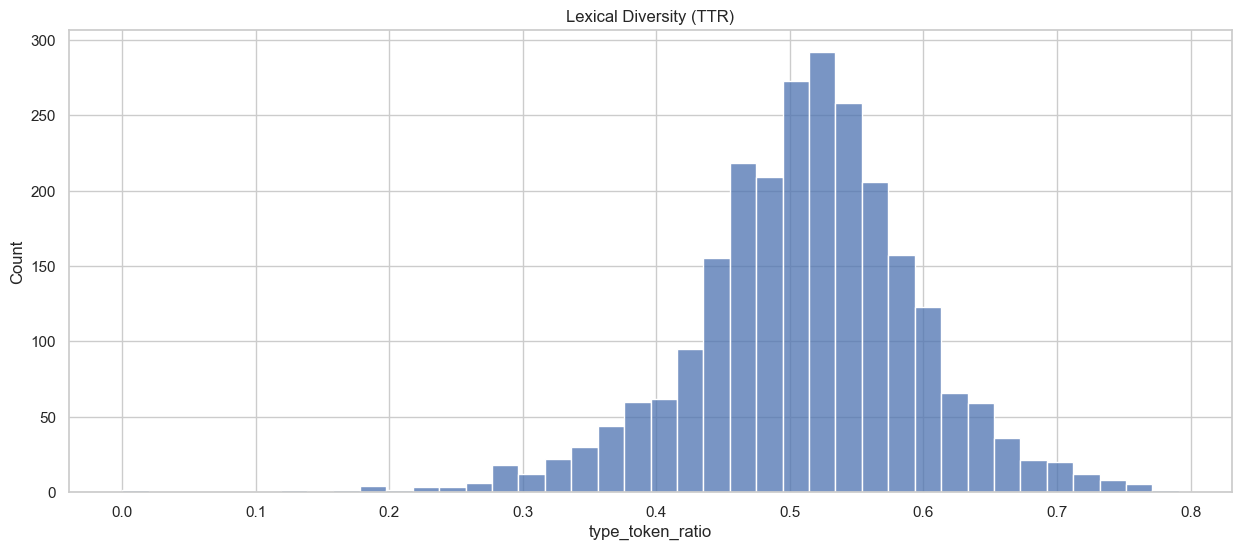

In [20]:
def text_stats(text):
    doc = nlp(text)
    words = [t.text for t in doc if t.is_alpha]
    types = set(words)
    sentences = list(doc.sents)
    return pd.Series({
        "sent_len": np.mean([len(sent) for sent in sentences]) if sentences else 0,
        "type_token_ratio": len(types)/len(words) if words else 0
    })

df_res[["sent_len", "type_token_ratio"]] = df_res["Resume_str"].apply(text_stats)
sns.histplot(df_res["type_token_ratio"], bins=40)
plt.title("Lexical Diversity (TTR)")
plt.show()

### Temporal Dynamics (Job Descriptions)

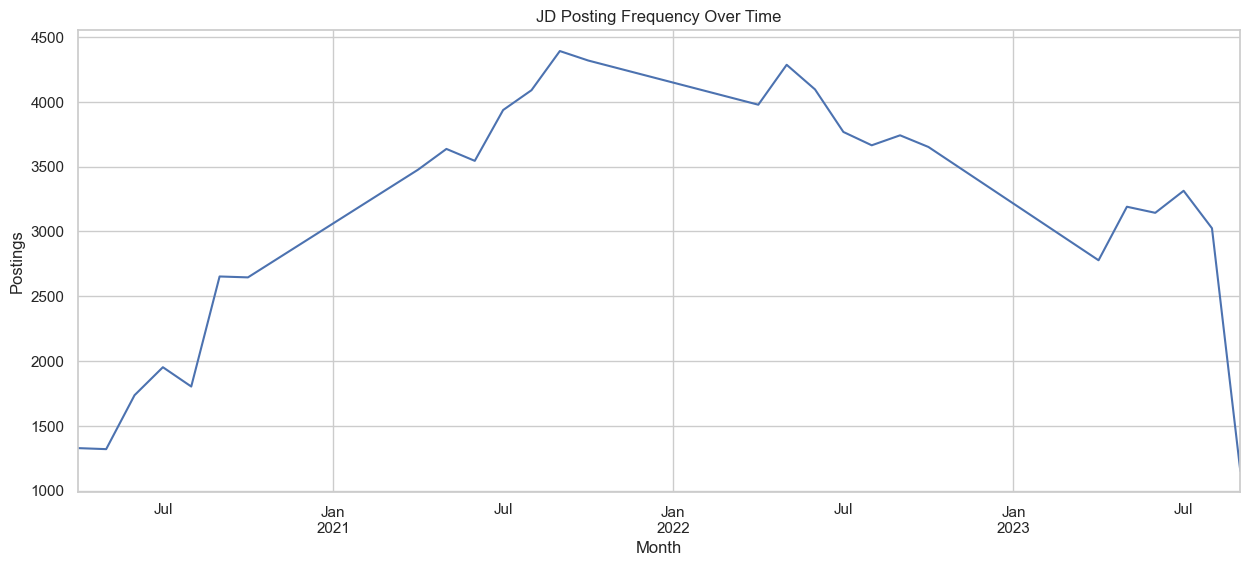

In [22]:
df_jd["Published"] = pd.to_datetime(df_jd["Published"], errors='coerce')

(
    df_jd.loc[df_jd["Published"].notna(), "Published"]
    .dt.to_period("M")
    .value_counts()
    .sort_index()
    .plot(kind="line")
)

plt.title("JD Posting Frequency Over Time")
plt.xlabel("Month")
plt.ylabel("Postings")
plt.show()

### Categorical Balancing

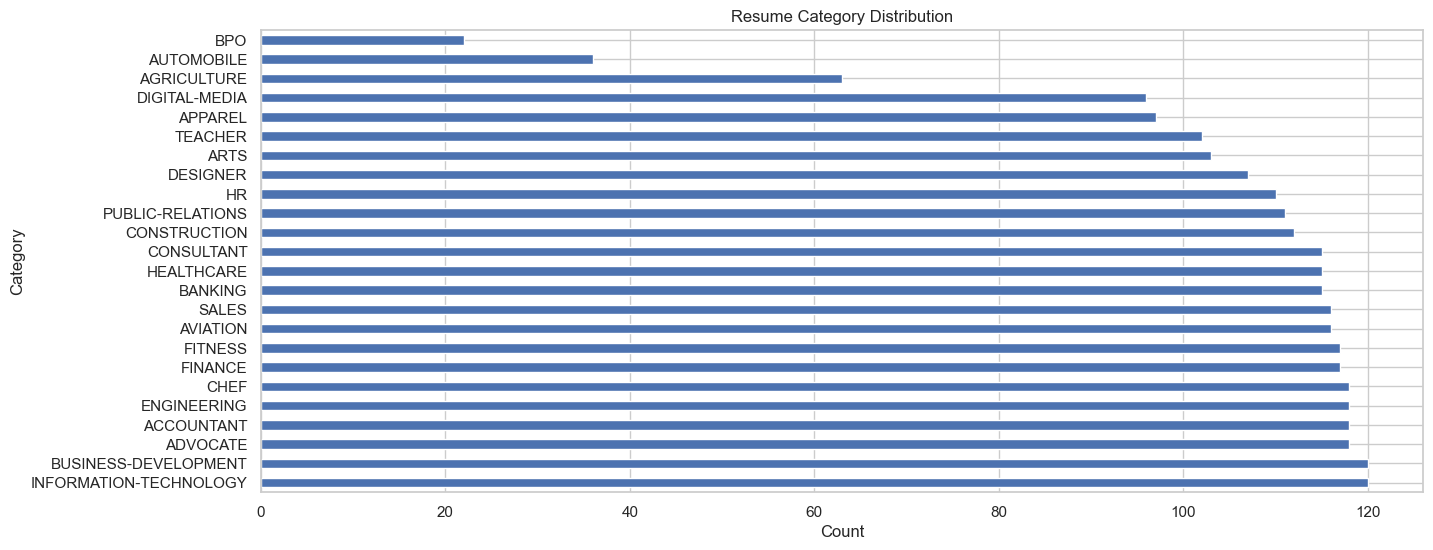

In [23]:
df_res["Category"].value_counts().plot(kind="barh")
plt.title("Resume Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

### Vocabulary & Skill Landscape

In [24]:
# Top n-grams
cv_res = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_res = cv_res.fit_transform(df_res['Resume_str'])
res_vocab = cv_res.get_feature_names_out()
res_counts = np.array(X_res.sum(axis=0)).flatten()

cv_jd = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_jd = cv_jd.fit_transform(df_jd['Long Description'])
jd_vocab = cv_jd.get_feature_names_out()
jd_counts = np.array(X_jd.sum(axis=0)).flatten()

# Vocabulary Overlap
overlap = len(set(res_vocab) & set(jd_vocab)) / len(set(res_vocab) | set(jd_vocab))
print("Jaccard Token Overlap:", round(overlap * 100, 2), "%")

Jaccard Token Overlap: 31.06 %


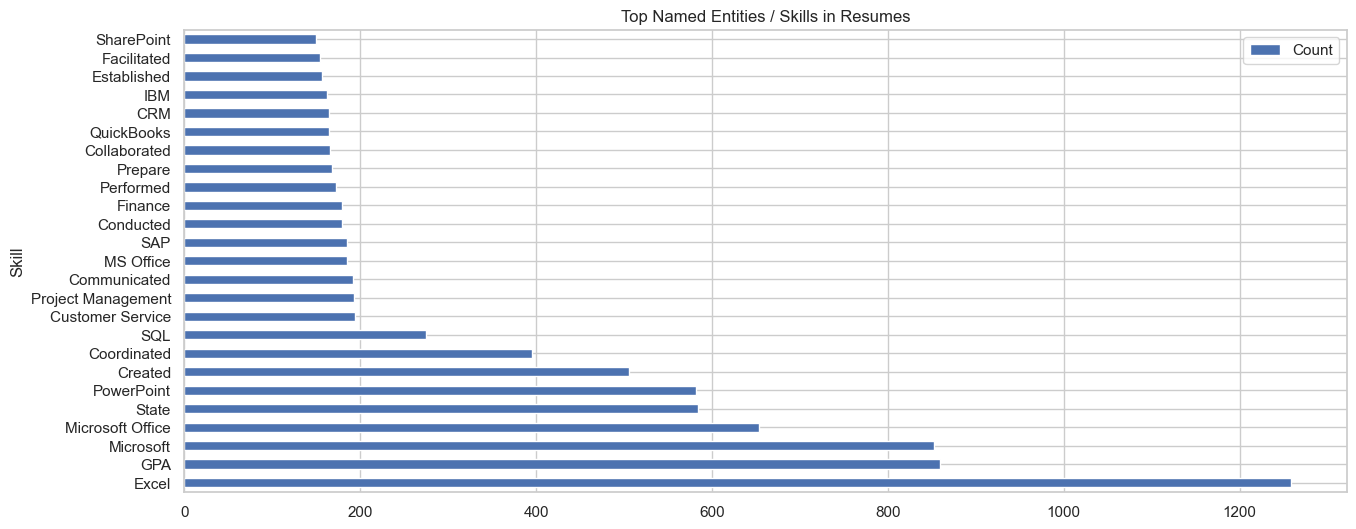

In [25]:
def extract_skills(txt):
    doc = nlp(txt)
    return [ent.text for ent in doc.ents if ent.label_ in {"ORG", "PRODUCT", "SKILL", "WORK_OF_ART"}]

skill_counter_res = collections.Counter(itertools.chain.from_iterable(df_res['Resume_str'].map(extract_skills)))
pd.DataFrame(skill_counter_res.most_common(25), columns=["Skill", "Count"]).plot(kind="barh", x="Skill")
plt.title("Top Named Entities / Skills in Resumes")
plt.show()

### Doc Embeddings & Semantic Projection

Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.91it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


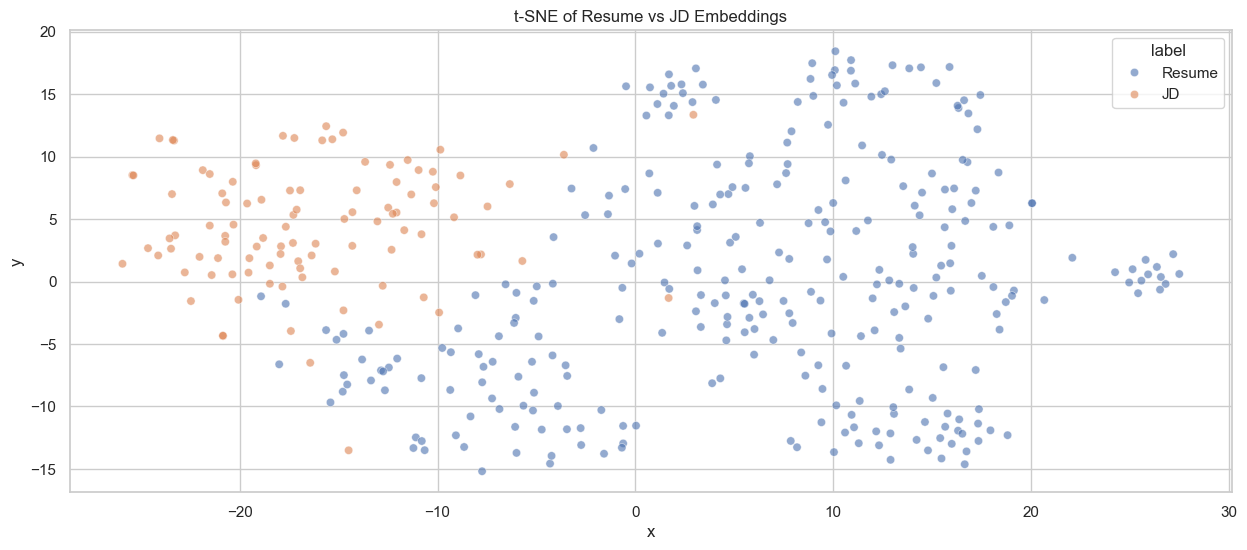

In [26]:
model = SentenceTransformer("all-MiniLM-L6-v2")
res_sample = df_res['Resume_str'].sample(300, random_state=0)
jd_sample = df_jd['Long Description'].sample(100, random_state=0)

res_emb = model.encode(res_sample.tolist(), show_progress_bar=True)
jd_emb = model.encode(jd_sample.tolist(), show_progress_bar=True)

all_embs = np.vstack([res_emb, jd_emb])
labels = ["Resume"] * len(res_emb) + ["JD"] * len(jd_emb)

proj = TSNE(n_components=2, perplexity=30).fit_transform(all_embs)
df_proj = pd.DataFrame(proj, columns=["x", "y"])
df_proj["label"] = labels

sns.scatterplot(data=df_proj, x="x", y="y", hue="label", alpha=0.6)
plt.title("t-SNE of Resume vs JD Embeddings")
plt.show()

### Text Similarity Baseline

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

sample_jd = df_jd["Long Description"].sample(1, random_state=42).values[0]
all_resumes = df_res["Resume_str"].sample(500, random_state=42).tolist()

jd_vec = model.encode([sample_jd])
res_vecs = model.encode(all_resumes)

sims = cosine_similarity(jd_vec, res_vecs).flatten()
top_k = np.argsort(sims)[-5:]
print("Top 5 Resume Similarities:\n", sims[top_k])

Top 5 Resume Similarities:
 [0.5956635  0.5966016  0.6087322  0.61313635 0.64748734]


### Fairness & Bias Reconnaissance

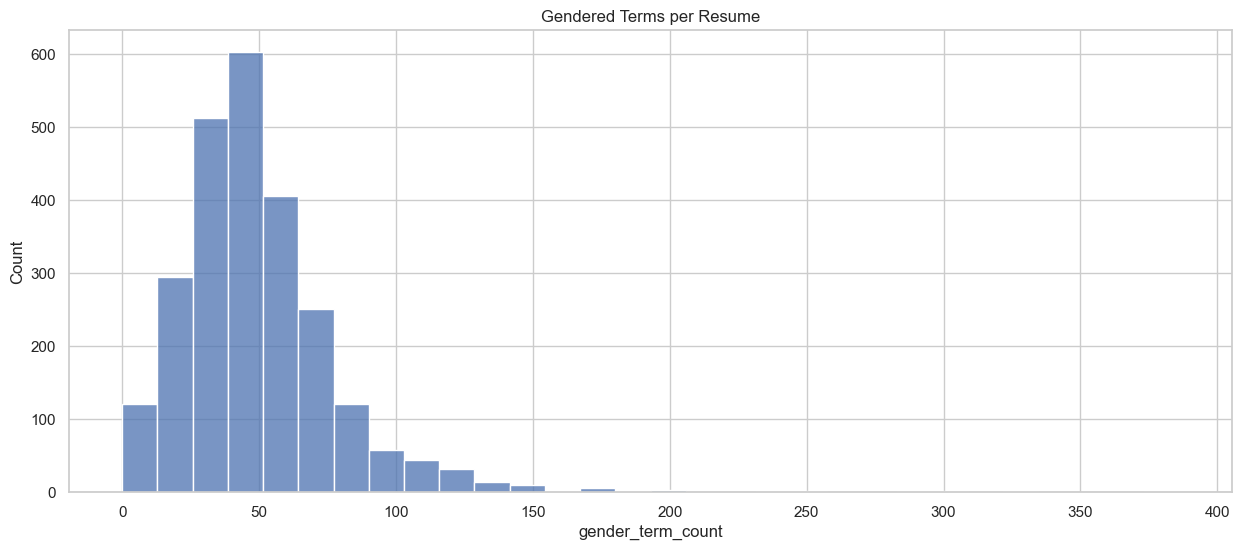

In [28]:
gendered_terms = ["he", "she", "his", "her", "man", "woman"]
df_res["gender_term_count"] = df_res["Resume_str"].apply(lambda x: sum(x.lower().count(t) for t in gendered_terms))
sns.histplot(df_res["gender_term_count"], bins=30)
plt.title("Gendered Terms per Resume")
plt.show()

#### Length by Category

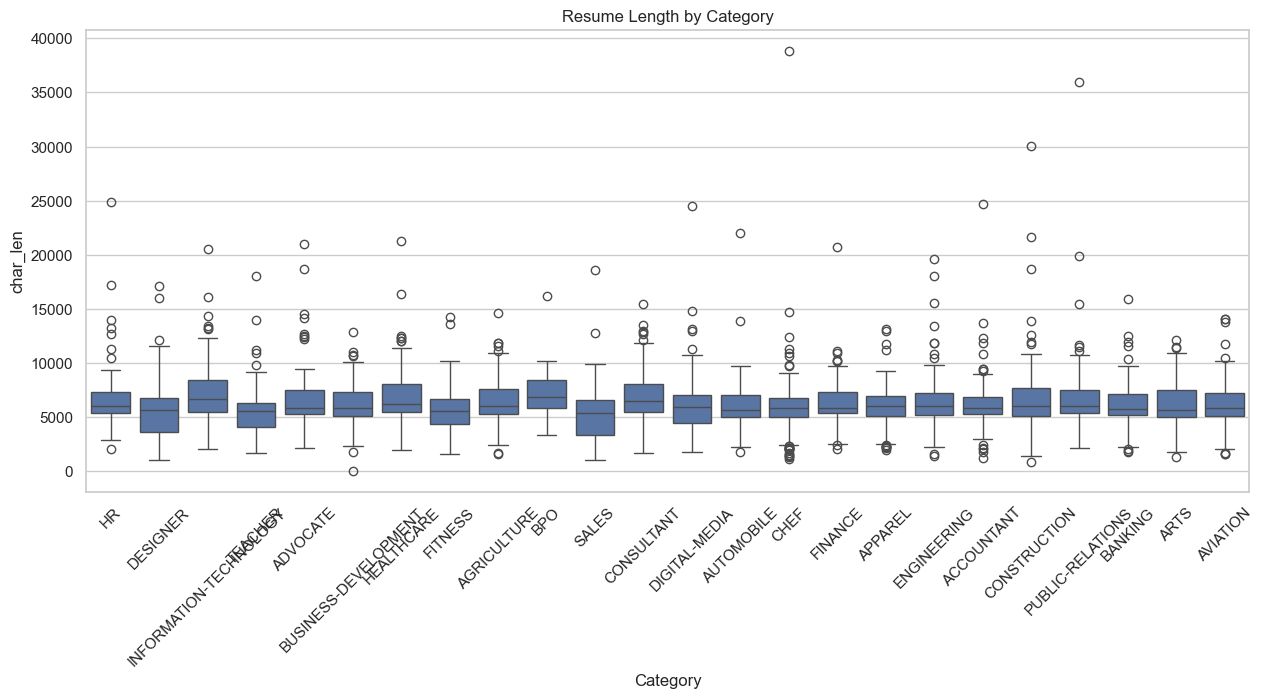

In [29]:
sns.boxplot(x='Category', y='char_len', data=df_res)
plt.title("Resume Length by Category")
plt.xticks(rotation=45)
plt.show()

### Data Quality Flags

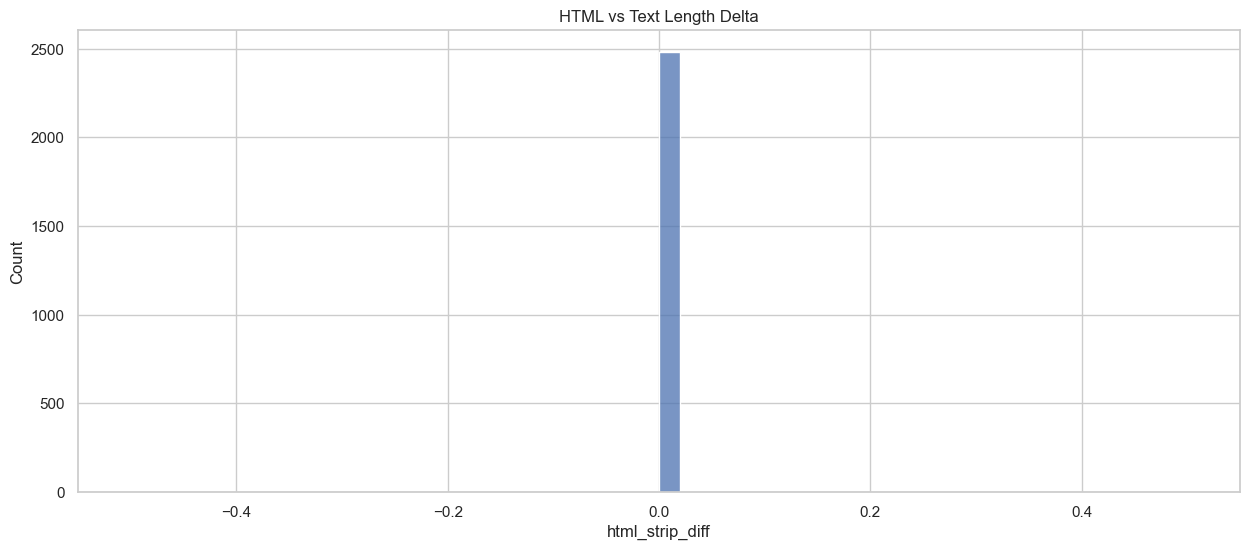

In [30]:
# HTML tag check
from bs4 import BeautifulSoup
df_res['html_len'] = df_res['Resume_html'].str.len()
df_res['text_from_html'] = df_res['Resume_html'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
df_res['html_strip_diff'] = df_res['Resume_str'].str.len() - df_res['text_from_html'].str.len()

sns.histplot(df_res["html_strip_diff"], bins=50)
plt.title("HTML vs Text Length Delta")
plt.show()

### EDA Summary Recap

In [31]:
print("✔ Total resumes:", len(df_res))
print("✔ Total JDs:", len(df_jd))
print("✔ Avg resume length:", df_res['char_len'].mean())
print("✔ Avg JD length:", df_jd['char_len'].mean())
print("✔ Token Overlap %:", round(overlap * 100, 2))
print("✔ Mean Resume TTR:", df_res['type_token_ratio'].mean())
print("⚠ Resumes with gender terms:", (df_res["gender_term_count"] > 0).mean() * 100, "%")

✔ Total resumes: 2482
✔ Total JDs: 141897
✔ Avg resume length: 6296.17929089444
✔ Avg JD length: 1800.62496035857
✔ Token Overlap %: 31.06
✔ Mean Resume TTR: 0.5119949626582981
⚠ Resumes with gender terms: 99.87912973408541 %


In [32]:
# Save resume dataset
df_res.to_csv("resumes.csv", index=False)

# Save job description dataset
df_jd.to_csv("job_descriptions.csv", index=False)